In [1]:
from copy import deepcopy
from datetime import datetime, timedelta
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import StrMethodFormatter
from prophet import Prophet

plt.rcParams['figure.figsize'] = 9, 6

In this tutorial we deep dive into some strategies for multivariate forecasting using Prophet. In particular, we walk through an approach to segment-level forecasts using the top-level series as an extra regressor.

### Dataset for case study - Pedestrian traffic by location

We use the pedestrians dataset from the City of Melbourne, which measures foot traffic at various locations in the Central Businesse District (CBD). We want to forecast the pedestrian traffic at each of these locations; we can think of this as a multivariate forecasting problem, or producing "segment-level" forecasts.

The dataset has been cleaned and aggregated to contain daily counts by location, in long form (i.e. one row per day + location), shown below. We have 10 different sensor locations, and the aim is to produce accurate out-of-sample forecasts for each.

In [2]:
peds = pd.read_csv("https://raw.githubusercontent.com/tcuongd/prophet/tcuongd-multivariate/examples/example_pedestrians_multivariate.csv", parse_dates=['ds'])

In [3]:
peds

,sensor_id,ds,y,sensor_description
0,1,2010-01-01,14024,Bourke Street Mall (North)
1,1,2010-01-02,18895,Bourke Street Mall (North)
2,1,2010-01-03,14775,Bourke Street Mall (North)
3,1,2010-01-04,21857,Bourke Street Mall (North)
4,1,2010-01-05,20640,Bourke Street Mall (North)
...,...,...,...,...
24626,15,2016-12-27,16790,State Library
24627,15,2016-12-28,17008,State Library
24628,15,2016-12-29,14963,State Library
24629,15,2016-12-30,18702,State Library


In [4]:
segments = peds['sensor_description'].unique()
segments

array(['Bourke Street Mall (North)', 'Bourke Street Mall (South)',
       'Princes Bridge', 'Flinders Street Station Underpass',
       'Webb Bridge', 'Southern Cross Station', 'Waterfront City',
       'New Quay', 'Flagstaff Station', 'State Library'], dtype=object)

In [5]:
peds['ds'].min(), peds['ds'].max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

#### Missing dates for certain segments

Often, the way we collect data for segment-level forecasts leads to missing dates for certain segments. This can happen as a result of the segment having a **zero** value for that date, or as a result of a bug in data collection. It's important to distinguish between the two scenarios, otherwise the model training and model evaluation could be biased. For example, during model training, if we ignore all zeroes (which is what happens if we pass the data with missing dates to Prophet as-is), the trend level of the model will be overstated. Then during model validation, `NA` values are often excluded when calculating evaluation metrics, so we're not properly assessing how well the model predicts zero values.

In this dataset, all locations are in the city central and should have pedestrian traffic every day (this is before COVID-19, remember!), so any missing values are likely a result of a physical fault with the sensor or loss of data. This means we do want these values to be `NA` (so they can be excluded from training and validation), and it's good to be explicit about this.

Below we fill in any missing dates for each segment. We also rename the column describing the sensor locations to `segment`.

In [6]:
def clean_data(df: pd.DataFrame, segment_col, missing_fill):
    """
    Ensures each segment has a measurement for each date between the min and max time within the dataframe.

    Fills missing measurements with `fill_value`, which defaults to 0.
    """
    min_date = df['ds'].min()
    max_date = df['ds'].max()
    dates = pd.DataFrame({'ds': pd.date_range(start=min_date, end=max_date, freq='D')})
    segs = pd.DataFrame({'segment': df[segment_col].unique()})
    base_table = pd.merge(dates, segs, how='cross')
    base_table = pd.merge(base_table, df[['ds', segment_col, 'y']].rename(columns={segment_col: 'segment'}), on=['ds', 'segment'], how='left')
    base_table['y'] = base_table['y'].fillna(missing_fill)
    return base_table.sort_values(['segment', 'ds'])

In [7]:
df = clean_data(peds, 'sensor_description', missing_fill=np.nan)

In [8]:
df

,ds,segment,y
0,2010-01-01,Bourke Street Mall (North),14024.0
10,2010-01-02,Bourke Street Mall (North),18895.0
20,2010-01-03,Bourke Street Mall (North),14775.0
30,2010-01-04,Bourke Street Mall (North),21857.0
40,2010-01-05,Bourke Street Mall (North),20640.0
...,...,...,...
25524,2016-12-27,Webb Bridge,2388.0
25534,2016-12-28,Webb Bridge,2841.0
25544,2016-12-29,Webb Bridge,2540.0
25554,2016-12-30,Webb Bridge,3124.0


### Evaluation criteria

To compare the performance of our modelling strategies, we perform 10-fold cross-validation using the latest year in the data (2016) for validation, with validation horizons of 28 days. `SMAPE` will be the evaluation metric for the out-of-sample forecasts.

In [9]:
train_start = datetime(2010, 1, 1)
val_horizon_days = 28
num_vals = 5
val_starts = sorted([datetime(2016, 12, 31) - timedelta(days=val_horizon_days) * i for i in range(1, num_vals + 1)])

In [10]:
def calculate_smape(y: np.array, yhat: np.array) -> float:
    abs_error = np.abs(y - yhat)
    denom = (np.abs(y) + np.abs(yhat)) / 2
    smape = np.nanmean(abs_error / denom)
    return smape

### Prophet configuration

Here we define our Prophet settings. Since the purpose of the exercise is to evaluate the top-level-regressor modelling strategy, we won't change the default values too much. There are a few things we know about the time series that we want to capture though:

* There is day-of-week and month-of-year seasonality in foot traffic (more going out on Fridays and weekends, less people out in the colder months of the year).
* Seasonality is likely multiplicative rather than additive, especially given the population growth in Melbourne.
* We want to use more of the recent data for estimating the trend, given the population growth in Melbourne.

We'll also be looking at how the different modelling strategies affect the confidence of our predictions, so we modify the `interval_width` to capture a 90% credible interval, and increase the number of uncertainty samples to 5,000 to get more stable lower and upper bound estimates.

For the cross-validation procedure, we define a function that fits up to a certain date in the dataframe history, then predicts on the validation period dates.

In [11]:
model = Prophet(
    changepoint_range=0.95,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative', 
    interval_width=0.90,
    uncertainty_samples=5000,
)

In [12]:
def train_validate(df: pd.DataFrame, val_start: datetime, val_end: datetime, model: Prophet) -> pd.DataFrame:
    train = df.loc[df['ds'] < val_start]
    val = df.loc[(df['ds'] >= val_start) & (df['ds'] < val_end)]
    model = model.fit(train)
    oos_preds = model.predict(val)
    oos_preds['y'] = val['y'].values
    return oos_preds

## Strategy 1: Independent Models

This will be our simple baseline - modelling each segment using only the data in the segment. For each segment, we output the out-of-sample prediction dataframe for each cross-validation fold.

In [13]:
start = datetime.now()

In [14]:
oos_independent = {}
for segment, df_segment in df.groupby('segment'):
    oos_independent[segment] = {}
    for val_start in val_starts:
        val_end = val_start + timedelta(days=val_horizon_days)
        segment_model = deepcopy(model)
        oos_independent[segment][str(val_start)] = train_validate(df_segment, val_start, val_end, segment_model)

In [15]:
end = datetime.now()

In [16]:
print(end - start)

0:05:39.313881


## Strategy 2: Top-level regressor

This is the strategy we're interested in exploring in this tutorial. The strategy is outlined [here](https://github.com/facebook/prophet/issues/49#issuecomment-430383681) by Ben Letham. It involves treating the groups of time series as a hierarchy, with a "top-level" time series that combines them.

The approach involves:

1. Forecasting the top-level series, including any future values.

Note that for cross-validation, we need to use the **forecasted** top-level series values, rather than the true values. This is to prevent information leakage, as the top-level series values would not be known when we actually try to forecast the future.

For the top-level series model, we simply use the same Prophet configurations described in the beginning. This is reasonable, as we would expect the top-level time series to have the same characteristics its constituent segments.

2. Using the historical data from the top-level series, and the future prediction values, as an additional regressor for the time series of each segment.

This means the model used for each segment becomes: 

$y_t = (1 + \mathrm{seasonality}_t) * \mathrm{trend}_t + \beta * \mathrm{top level}_t$

Having the top-level series in the model effectively includes information about the growth and seasonality of other segments, which we hypothesize will help produce more accurate segment-level forecasts.

We configure the top-level regressor in the Prophet model as follows:

* The top-level regressor values are standardized (predictors are typically standardized, and there's no reason to shift from this).
* We assume the relationship is additive. This is simpler to interpret.
* We use a `prior_scale` of 1.0. This is much lower than the default prior scale of 10.0 used for holidays. However, given we are standardizing the top-level values, such a large prior scale value doesn't provide much regularization. Note that we use the same scale for all segments, but conceivably we could also change this value per segment. For example, if we were confident that a particular segment's trajectory is better determined by its own data (because its growth drivers are very different to that of other segments), we could set a lower prior scale to pull $\beta$ closer to 0.

In [17]:
df_toplevel = df.groupby('ds', as_index=False).agg({'y': 'sum'})

In [18]:
start = datetime.now()

In [19]:
regressor_mode = 'additive'
oos_toplevelregr = {s: {} for s in segments}
for val_start in val_starts:
    val_end = val_start + timedelta(days=val_horizon_days)
    toplevel_model = deepcopy(model)
    toplevel_history = df_toplevel.loc[df_toplevel['ds'] < val_start, ['ds', 'y']].rename(columns={'y': 'top_level'})
    toplevel_oos = train_validate(df_toplevel, val_start, val_end, toplevel_model)[['ds', 'yhat']].rename(columns={'yhat': 'top_level'})
    toplevel = pd.concat([toplevel_history, toplevel_oos], ignore_index=True)
    for segment, df_segment in df.groupby('segment'):
        segment_model = deepcopy(model)
        segment_model.add_regressor('top_level', standardize=True, mode=regressor_mode, prior_scale=1.0)
        model_df = pd.merge(df_segment, toplevel, on='ds', how='left')
        model_df['top_level'] = model_df['top_level'].fillna(method='ffill')
        oos_toplevelregr[segment][str(val_start)] = train_validate(model_df, val_start, val_end, segment_model)

In [20]:
end = datetime.now()

In [21]:
print(end - start)

0:06:16.354342


## Comparison

### Visual comparison of out-of-sample predictions

First we'll do a visual comparison of the out-of-sample actuals vs. forecasts under each strategy, for each segment of interest.

In [22]:
def extract_predictions(
    oos_independent: Dict[str, Dict[str, pd.DataFrame]], 
    oos_toplevelregr: Dict[str, Dict[str, pd.DataFrame]], 
    segment: str
):
    preds_independent = pd.concat(oos_independent[segment], axis=0, names=['val_start']).reset_index()
    preds_toplevelregr = pd.concat(oos_toplevelregr[segment], axis=0, names=['val_start']).reset_index()
    preds = pd.merge(
        preds_independent[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']],
        preds_toplevelregr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
        on='ds',
        how='inner',
        suffixes=('_independent', '_toplevelregr')
    )
    return preds

In [23]:
def plot_segment(
    oos_independent: Dict[str, Dict[str, pd.DataFrame]],
    oos_toplevelregr: Dict[str, Dict[str, pd.DataFrame]],
    segment: str,
    ax=None
):
    plot_df = extract_predictions(oos_independent, oos_toplevelregr, segment)
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(plot_df['ds'], plot_df['y'], marker=".", c="black", linestyle="")
    ax.plot(plot_df['ds'], plot_df['yhat_independent'], label='yhat_independent')
    ax.fill_between(x=plot_df['ds'], y1=plot_df['yhat_lower_independent'], y2=plot_df['yhat_upper_independent'], alpha=0.2)
    ax.plot(plot_df['ds'], plot_df['yhat_toplevelregr'], label='yhat_toplevelregr')
    ax.fill_between(x=plot_df['ds'], y1=plot_df['yhat_lower_toplevelregr'], y2=plot_df['yhat_upper_toplevelregr'], alpha=0.2)
    ax.set_title(segment)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    ax.legend()
    
    return ax

In [24]:
def plot_all():
    rows, cols = 5, 2
    fig, axs = plt.subplots(
        nrows=rows, 
        ncols=cols, 
        sharex=True, 
        figsize=np.array(plt.rcParams['figure.figsize']) * np.array([cols, rows])
    )
    for segment, ax in zip(segments, axs.flat):
        plot_segment(oos_independent, oos_toplevelregr, segment, ax)
    fig.autofmt_xdate()
    plt.tight_layout()
    
    return fig

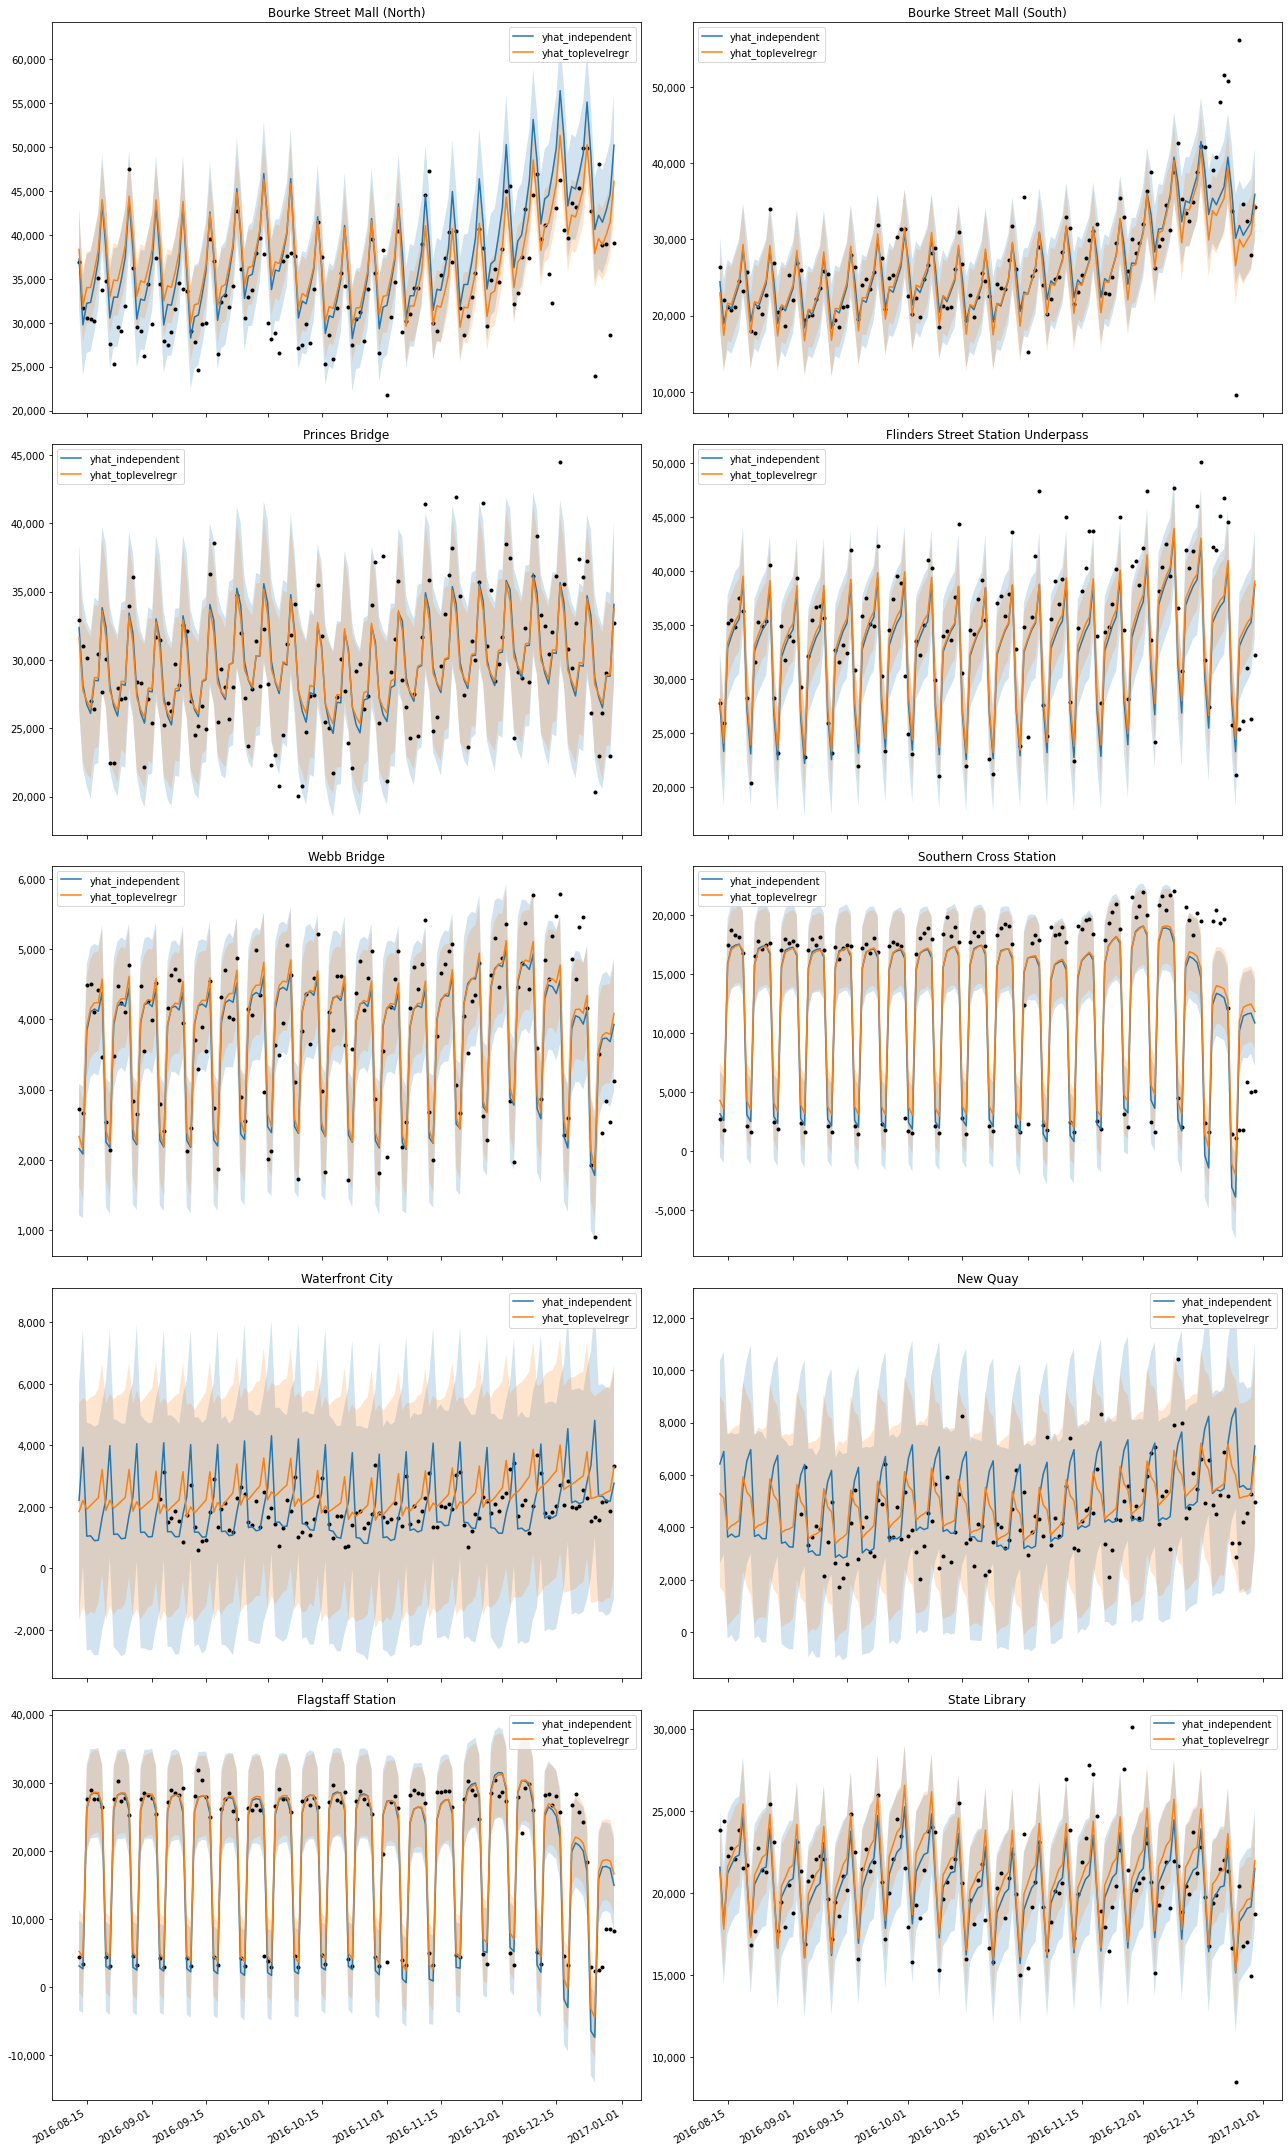

In [25]:
plot_all();

### `SMAPE` comparisons

Lower `SMAPE` values are better.

In [26]:
def summarise_smape(
    oos_independent: Dict[str, Dict[str, pd.DataFrame]], 
    oos_toplevelregr: Dict[str, Dict[str, pd.DataFrame]], 
):
    smape_summ = []
    for segment in segments:
        preds = extract_predictions(oos_independent, oos_toplevelregr, segment)
        smape_i = calculate_smape(preds['y'], preds['yhat_independent'])
        smape_tlr = calculate_smape(preds['y'], preds['yhat_toplevelregr'])
        smape_summ.append(pd.DataFrame([[segment, smape_i, smape_tlr]], columns=['segment', 'smape_independent', 'smape_toplevelregr'], index=[0]))
    smape_summ = pd.concat(smape_summ, ignore_index=True).set_index('segment')
    smape_summ['diff_toplevelregr'] = smape_summ['smape_toplevelregr'] - smape_summ['smape_independent']
    return smape_summ

In [27]:
smape_summary = summarise_smape(oos_independent, oos_toplevelregr)

In [28]:
smape_summary.style.format("{:.2%}")

,smape_independent,smape_toplevelregr,diff_toplevelregr
segment,,,
Bourke Street Mall (North),11.05%,11.32%,0.27%
Bourke Street Mall (South),8.91%,10.30%,1.39%
Princes Bridge,9.84%,9.86%,0.02%
Flinders Street Station Underpass,9.15%,8.54%,-0.62%
Webb Bridge,13.32%,13.02%,-0.30%
Southern Cross Station,26.34%,30.36%,4.01%
Waterfront City,33.79%,37.13%,3.34%
New Quay,24.67%,23.45%,-1.22%
Flagstaff Station,28.09%,20.35%,-7.73%


In [29]:
smape_summary['diff_toplevelregr'].describe()

count    10.000000
mean      0.000176
std       0.031982
min      -0.077346
25%      -0.005365
50%       0.001462
75%       0.012955
max       0.040113
Name: diff_toplevelregr, dtype: float64

### Uncertainty interval comparisons 

We compute two metrics:

1. The size of the uncertainty interval, i.e. `yhat_upper - yhat_lower`. Intuitively a smaller uncertainty interval suggests a better forecasts. **However**, the interval size for the top-level-regressor strategy is likely understated. We haven't performed full MCMC inference, so the uncertainty in the $\beta$ estimate is not accounted for, and we haven't incorporated the uncertainty of the top-level forecast either.
2. The proportion of `y` values that lie within the 90% uncertainty interval. The higher this metric the better, as it represents how well we can capture the full range of possible outcomes.

There is an inherent trade-off between these two metrics -- a model may predict a very wide uncertainty interval that's not very useful, but in doing so capture more possible `y` values. We need to look at the two metrics together to understand the quality of the uncertainty forecast under each strategy.

In [30]:
def summarise_uncertainty(
    oos_independent: Dict[str, Dict[str, pd.DataFrame]], 
    oos_toplevelregr: Dict[str, Dict[str, pd.DataFrame]], 
):
    uncertainty = []
    for segment in segments:
        preds = extract_predictions(oos_independent, oos_toplevelregr, segment)
        interval_size_i = np.mean(preds['yhat_upper_independent'] - preds['yhat_lower_independent'])
        interval_size_tlr = np.mean(preds['yhat_upper_toplevelregr'] - preds['yhat_lower_toplevelregr'])
        perc_within_i = np.mean((preds['y'] > preds['yhat_lower_independent']) & (preds['y'] < preds['yhat_upper_independent']))
        perc_within_tlr = np.mean((preds['y'] > preds['yhat_lower_toplevelregr']) & (preds['y'] < preds['yhat_upper_toplevelregr']))
        uncertainty.append(
            pd.DataFrame(
                [[segment, interval_size_i, interval_size_tlr, perc_within_i, perc_within_tlr]], 
                columns=['segment', 'interval_size_independent', 'interval_size_toplevelregr', 'perc_within_independent', 'perc_within_toplevelregr'], 
                index=[0]
            )
        )
    uncertainty = pd.concat(uncertainty, ignore_index=True).set_index('segment')
    uncertainty['interval_size_diff'] = uncertainty['interval_size_toplevelregr'] - uncertainty['interval_size_independent']
    uncertainty['perc_within_diff'] = uncertainty['perc_within_toplevelregr'] - uncertainty['perc_within_independent']
    return uncertainty

In [31]:
uncertainty = summarise_uncertainty(oos_independent, oos_toplevelregr)

In [32]:
uncertainty[[c for c in uncertainty.columns if c.startswith('interval_size')]].style.format("{:,.0f}")

,interval_size_independent,interval_size_toplevelregr,interval_size_diff
segment,,,
Bourke Street Mall (North),"11,579","8,254","-3,325"
Bourke Street Mall (South),"11,827","9,735","-2,093"
Princes Bridge,"12,008","10,446","-1,562"
Flinders Street Station Underpass,"9,813","6,767","-3,046"
Webb Bridge,"1,856","1,422",-434
Southern Cross Station,"7,211","6,488",-723
Waterfront City,"7,442","6,933",-509
New Quay,"7,795","7,189",-606
Flagstaff Station,"13,112","11,961","-1,151"


In [33]:
uncertainty['interval_size_diff'].describe()

count      10.000000
mean    -1561.769128
std      1060.700884
min     -3325.250832
25%     -2148.655732
50%     -1356.865410
75%      -635.473939
max      -434.212460
Name: interval_size_diff, dtype: float64

In [34]:
uncertainty[[c for c in uncertainty.columns if c.startswith('perc_within')]].style.format("{:.2%}")

,perc_within_independent,perc_within_toplevelregr,perc_within_diff
segment,,,
Bourke Street Mall (North),75.00%,59.29%,-15.71%
Bourke Street Mall (South),94.29%,86.43%,-7.86%
Princes Bridge,86.43%,82.14%,-4.29%
Flinders Street Station Underpass,76.43%,67.14%,-9.29%
Webb Bridge,91.43%,84.29%,-7.14%
Southern Cross Station,85.71%,87.14%,1.43%
Waterfront City,85.00%,85.00%,0.00%
New Quay,82.86%,84.29%,1.43%
Flagstaff Station,91.43%,92.14%,0.71%


In [35]:
uncertainty['perc_within_diff'].describe()

count    10.000000
mean     -0.054286
std       0.063102
min      -0.157143
25%      -0.089286
50%      -0.057143
75%       0.005357
max       0.014286
Name: perc_within_diff, dtype: float64